In [1]:
# Import required libraries
import sys
import tqdm
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt

## Test Data Generation

In [6]:
# Function to get matplotlib figure
def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

# Function to plot 2D data points
def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )

# Function to generate crescent data points
def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

# Function to generate spherical data points
def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [3]:
rnd.seed(101)

d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

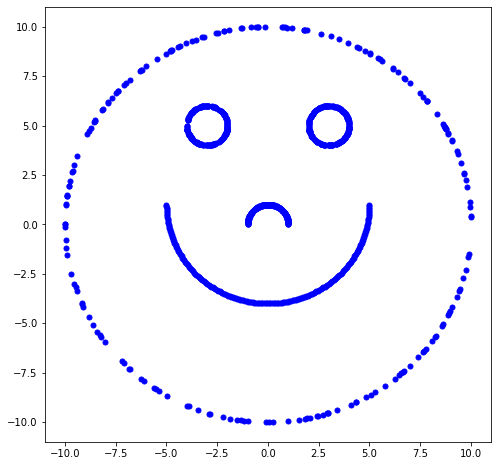

In [5]:
# Visualize generated dataset
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 25, color = 'b', marker = 'o' )

## K-Means

**Convergence Criteria:** <br>
If the Euclidean Distance (L2 Norm) between the cluster centers at two consecutive iterations is less than the tolerance value, then the algorithm is assumed to have converged.

**Distortion (Loss):** <br>
$$ Loss: \sum_{k=1}^{K} \ \sum_{n: z_{n}=k} (x_{n}-\mu_{k})^{2} $$

In [7]:
class K_Means:
    '''
    K-Means clustering.

    Parameters
    ----------
    n_clusters : int, default=4
        The number of clusters to form as well as the number of centroids to generate.

    max_iter : int, default=300
        Maximum number of iterations of the k-means algorithm for a single run.

    tol : float, default=1e-4
        Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.

    flag_convg : bool, default=True
        Whether to check for convergence of algorithm by tolerance or not.

    verbose : bool, default=True
        Whether to display details like progress bar, iterations & ETA.

    seed : int, default=101
        Seed for pseudo-random number generator.

    Attributes
    ----------
    cluster_centers : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers (centroids).

    self.cluster_indices : dict with cluster_id(s) as keys and list of indices of data points belonging to that cluster as values
        Indices of clustered data points.

    n_iter : int
        Number of iterations run.
    
    '''

    def __init__(self, n_clusters=4, tol=1e-4, max_iter=300, flag_convg=True, verbose=True, seed=101):
        self.n_clusters = n_clusters
        self.tol = tol
        self.max_iter = max_iter
        self.flag_convg = flag_convg
        self.verbose = verbose
        self.seed = seed
        self.cluster_indices = None
        self.cluster_centers = None


    def dist(self, data_points, cluster_center):
        '''
        Compute Euclidean distance of data points from cluster center

        Parameters:
        -----------
        data_points : array-like of shape (n_samples, n_features)
            Array of data points.

        cluster_center : array-like of shape (1, n_features)
            Cluster center.

        Returns
        -------
        dist : array-like of shape (n_samples, )
            Euclidean Distances from cluster center.
        '''
        return lin.norm(data_points - cluster_center, axis=1)


    def init_cluster_centers(self, X):
        '''
        Initialize cluster centers randomly from training samples.

        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training instances to cluster.

        '''
        
        n_samples, n_features = X.shape
        rnd.seed(self.seed)

        # Init an empty array for cluster centres if `cluster_centers is None`
        if self.cluster_centers is None:
            self.cluster_centers = np.empty((n_features, 0), dtype=X.dtype)

        # Assign random sample points as cluster centers
        for _ in range(self.n_clusters):
            self.cluster_centers = np.c_[self.cluster_centers, X[rnd.randint(0, n_samples-1)]]


    def fit_predict(self, X):
        '''
        Compute cluster centers and predict cluster index for each sample.

        Parameters|
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.

        Returns
        -------
        self : object
            Fitted estimator.
        '''

        n_samples, _ = X.shape

        # Init an empty dict to store the indices of data points clustered so far
        self.cluster_indices = {}

        # Init cluster centers
        self.init_cluster_centers(X)

        for iter in tqdm.tqdm(range(self.max_iter), disable=(not self.verbose)):
            # print(f'iter={iter}\n{self.cluster_centers}')

            # Init empty array to store distance(s)
            Distance = np.array([]).reshape(n_samples,0)

            # Find the distance(s) of data points from each centroid
            for k in range(self.n_clusters):
                tempDist = self.dist(X, self.cluster_centers[:, k])
                Distance = np.c_[Distance, tempDist]

            # Find the index of the column with minimum distance
            minimum = np.argmin(Distance, axis=1)

            # Init empty dict to store temporay cluster(s)
            for k in range(self.n_clusters):
                self.cluster_indices[k] = []

            # Assign clusters to data points
            for i in range(n_samples):
                self.cluster_indices[minimum[i]].append(i)

            # Update cluster centers (centroids)
            flag_optimized = True
            for k in range(self.n_clusters):
                if len(self.cluster_indices[k]) != 0: 
                    new_centers = np.mean(X[self.cluster_indices[k]], axis=0)
                else:
                    new_centers = np.nan
                orig_centers = self.cluster_centers[:, k]

                delta = lin.norm(new_centers - orig_centers)

                # Set `flag_optimized` as False if center(s) shifted more than tolerance in Euclidean Space 
                if (delta > self.tol) or (new_centers.any() == np.nan):
                    flag_optimized = False 

                self.cluster_centers[:, k] = new_centers

            # Break if `flag_optimized = True` i.e. algorithm has converged
            if flag_optimized & self.flag_convg:
                break

        self.n_iter = iter
        return self

    def get_loss(self ,X):
        ''' 
        Compute total distortion over all points w.r.t current clustering.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data points to compute the loss on.

        Returns
        -------
        loss : float
            Total loss (distortion) over all clusters.
        '''

        # Compute distortion (loss) for every cluster
        loss = 0.0
        for k in range(self.n_clusters):
            cluster_center = self.cluster_centers[:, k]
            cluster_points = X[self.cluster_indices[k]]
            loss += np.sum(self.dist(cluster_points, cluster_center))
        
        return loss

**Visualizing the results of kmeans clustering for different values K (Number of clusters) :** <br>

Note: Number of iterations to convergence can be observed in tqdm progress bar.

  4%|▍         | 13/300 [00:00<00:00, 1629.88it/s]


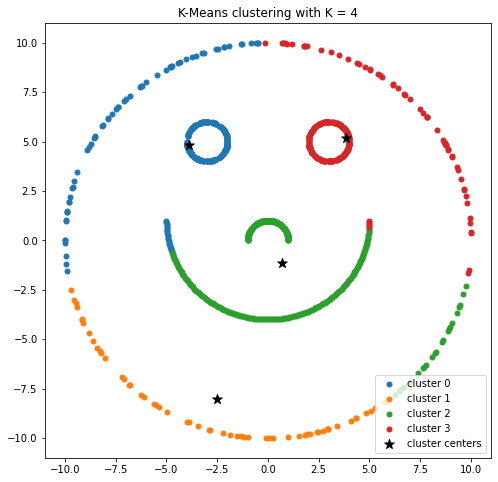

  4%|▍         | 12/300 [00:00<00:00, 1452.70it/s]


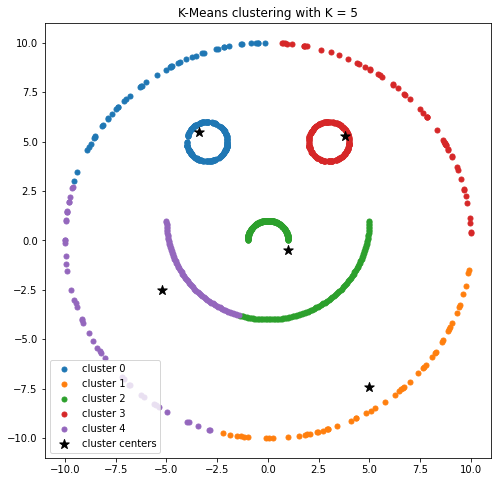

  7%|▋         | 21/300 [00:00<00:00, 1370.77it/s]


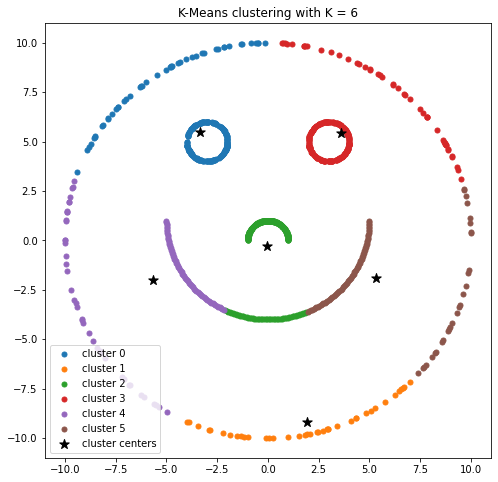

In [8]:
for K in [4, 5, 6]:
    # Init an estimator of class `K_Means` and call `fit_predict` method
    clf = K_Means(n_clusters=K, tol=1e-9, max_iter=300)
    clf.fit_predict(X)

    fig = getFigure(8, 8)

    # Plot data points
    for k in range(clf.n_clusters):
        idx = clf.cluster_indices[k]
        plt.scatter(X[idx, 0], X[idx, 1], s=25, label=f'cluster {k}')

    # Plot centroids
    plt.scatter(clf.cluster_centers[0, :], clf.cluster_centers[1, :], s=100, c='black', marker='*', label='cluster centers')

    plt.title(f'K-Means clustering with K = {K}')
    plt.legend()
    plt.show()

## K-Means++

In [9]:
class K_Means_plus_plus (K_Means):
    ''' 
    K-Means++ clustering algo which selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.

    Parameters
    ----------
    n_clusters : int, default=4
        The number of clusters to form as well as the number of centroids to generate.

    max_iter : int, default=300
        Maximum number of iterations of the k-means algorithm for a single run.

    tol : float, default=1e-4
        Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.

    flag_convg : bool, default=True
        Whether to check for convergence of algorithm by tolerance or not.

    verbose : bool, default=True
        Whether to display details like progress bar, iterations & ETA.

    Attributes
    ----------
    cluster_centers : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers (centroids).

    self.cluster_indices : dict with cluster_id(s) as keys and list of indices of data points belonging to that cluster as values
        Indices of clustered data points.

    n_iter : int
        Number of iterations run.
    '''

    def __init__(self, n_clusters=4, tol=0.0001, max_iter=300, flag_convg=True, verbose=True, seed=101):
        super().__init__(
            n_clusters=n_clusters,
            tol=tol,
            max_iter=max_iter,
            flag_convg=flag_convg,
            verbose=verbose,
            seed=seed
        )

    def init_cluster_centers(self, X):
        '''
        Initialize the cluster centers such that they are at maximum distance from each other
        
        Parameters:
        -----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.
        '''

        n_samples, _ = X.shape
        rnd.seed(self.seed)

        # Init the centroids list and add a randomly selected data point to the list
        centroids = []
        centroids.append(X[np.random.randint(n_samples), :])
    
        # Compute remaining `n_clusters - 1` centroids
        for _ in range(self.n_clusters - 1):
            
            # Init a list to store distances of data points from nearest centroid
            dist = []
            for i in range(n_samples):
                point = X[i, :]
                d = sys.maxsize
                
                # Compute the distance of `point` from each of the previously selected centroid and store the minimum distance
                for j in range(len(centroids)):
                    temp_dist = lin.norm(point - centroids[j])
                    d = min(d, temp_dist)
                dist.append(d)
                
            # Select data point with maximum distance as next centroid
            dist = np.array(dist)
            centroids.append(X[np.argmax(dist), :])

        # Assign the cluster centers
        self.cluster_centers = np.array(centroids).T

**Visualizing the results of k-means++ clustering for different values K (Number of clusters) :**<br>
K-Means++ uses the same function to cluster the data points, except the initialization of cluster centers is done smartly instead of radomly such that no two centers are close enough. This should improve the runtime of algorithm by making it converge faster.

Note: Number of iterations to convergence can be observed in tqdm progress bar.

  4%|▍         | 13/300 [00:00<00:00, 1699.58it/s]


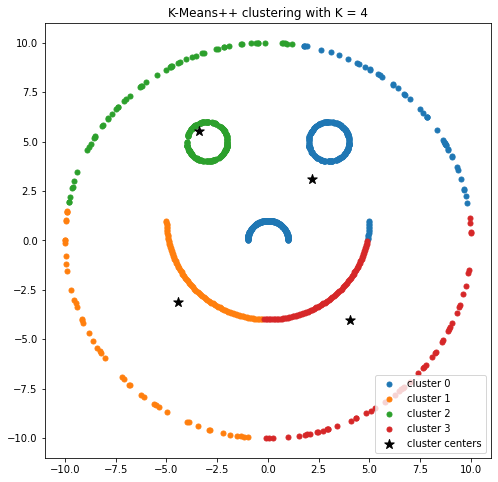

  8%|▊         | 24/300 [00:00<00:00, 1537.67it/s]


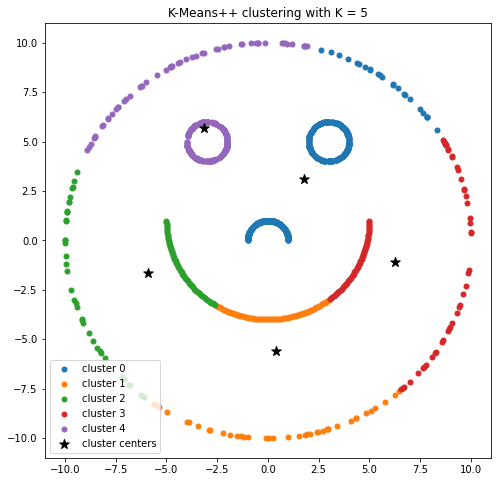

  8%|▊         | 25/300 [00:00<00:00, 1447.49it/s]


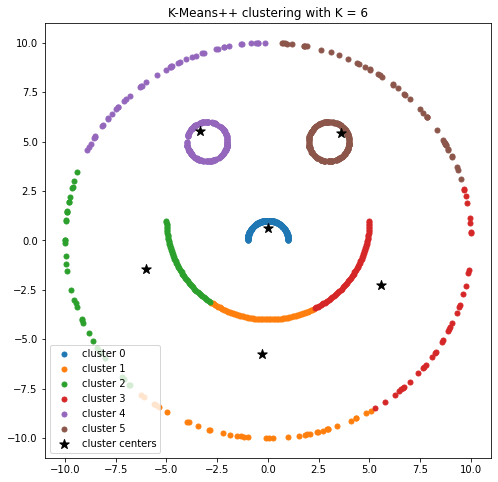

In [10]:
for K in [4, 5, 6]:
    # Init an estimator of class `K_Means_plus_plus` and call `fit_predict` method
    clf_kmpp = K_Means_plus_plus(n_clusters=K, tol=1e-6, max_iter=300)
    clf_kmpp.fit_predict(X)

    fig = getFigure(8, 8)

    for k in range(clf_kmpp.n_clusters):
        idx = clf_kmpp.cluster_indices[k]
        plt.scatter(X[idx, 0], X[idx, 1], s=25, label=f'cluster {k}')

    # Plot centroids
    plt.scatter(clf_kmpp.cluster_centers[0, :], clf_kmpp.cluster_centers[1, :], s=100, c='black', marker='*', label='cluster centers')

    plt.title(f'K-Means++ clustering with K = {K}')
    plt.legend()
    plt.show()

**Conclusion:**
The clustering results obtained with K-Means and K-Means++ don't differ by much. K-Means++ may converge faster at times as compared to standard K-Means because of better initialization of centroids. 

## Elbow Method

100%|██████████| 24/24 [00:08<00:00,  2.98it/s]


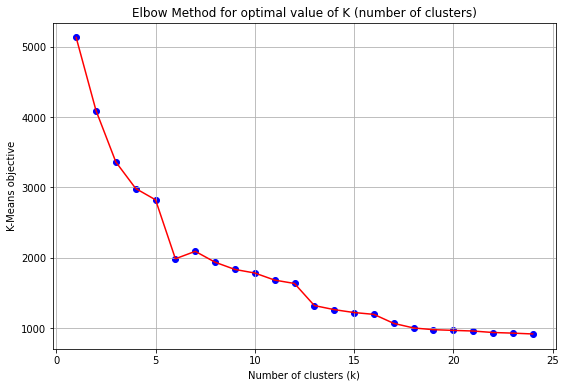

In [11]:
rnd.seed(101)

# Init an empty list to store `loss` at every `k`
loss_history = []

# Check for every value of `k`
for k in tqdm.tqdm(range(1, 25)):
    clf = K_Means_plus_plus(n_clusters=k, tol=1e-6, verbose=False).fit_predict(X)
    loss = clf.get_loss(X)

    # Append total distortion (loss) with current `k` (number of clusters)
    loss_history.append(loss)

# Plot "K-means objective vs Number of clusters"
plt.figure(figsize=(9,6))
plt.title('Elbow Method for optimal value of K (number of clusters)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('K-Means objective')
plt.grid(True)

x = np.array(range(1, len(loss_history)+1 ))
y = np.array(loss_history)

plt.scatter(x, y, c='b')
plt.plot(x, y, 'r-')
plt.show()

**Conclusion:** From the above plot, it is observed that Elbow Point seems to lie somewhere around 6. Therefore, the optimal value of K (number of clusters) is 6. <br> As observed earlier, quality of clustering with K=6 is poor as clusters are not spherical.

## Kernelized K-Means

**Gaussian Kernel:**
Gaussian kernel is a general purpose kernel, with equation :
$$
k(x_{i},x_{j})=exp \ (\frac{||x_{i}-x_{j}||^{2}}{2 \sigma^2})
$$
<br>
The above equation is used to generate kernel matrix.

In [12]:
class K_Means_kernelized (K_Means_plus_plus):
    '''
    K-Means clustering with a Gaussian RBF kernel.
    Gaussain RBF kernel: K(x_i, x_j) = exp ((-|x_i - x_j|**2) / 2sigma**2 )

    Parameters
    ----------
    n_clusters : int, default=4
        The number of clusters to form as well as the number of centroids to generate.

    sigma : float, default = 4.0
        Standard Deviation for Gaussian kernel matrix.

    max_iter : int, default=300
        Maximum number of iterations of the k-means algorithm for a single run.

    tol : float, default=1e-4
        Relative tolerance with regards to Frobenius norm of the difference in the cluster cluster_centers of two consecutive iterations to declare convergence.

    flag_convg : bool, default=True
        Whether to check for convergence of algorithm by tolerance or not.

    verbose : bool, default=True
        Whether to display details like progress bar, iterations & ETA.

    Attributes
    ----------
    cluster_cluster_centers : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster cluster_centers (centroids).

    self.cluster_indices : dict with cluster_id(s) as keys and list of indices of data points belonging to that cluster as values
        Indices of clustered data points.

    Gram : ndarray of shape (n_samples, n_samples)
        Training instances in the transformed space.

    n_iter : int
        Number of iterations run.
    
    '''

    def __init__(self, n_clusters=4, sigma=4.0, tol=0.0001, max_iter=300, flag_convg=True, verbose=True, seed=101):
        super().__init__(
            n_clusters=n_clusters,
            tol=tol,
            max_iter=max_iter,
            flag_convg=flag_convg,
            verbose=verbose,
            seed = seed
        )
        self.sigma = sigma
        self.Gram = None

    def transform(self, X, q=2):
        '''
        Compute the Gram matrix for K-Means.
        Transform the trainig instances using a Gaussian RBF kernel.

        Paramters:
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training instances to compute Gram matrix from.

        Returns:
        --------
        Gram : ndarray of shape (n_samples, n_samples)
            Gram matrix.
        '''

        n_samples, _ = X.shape

        # Init Gram matrix with all zeroes
        self.Gram = np.zeros(shape=(n_samples, n_samples))

        # Fill Gram matrix in row-major order
        for i in range(n_samples):
            for j in range(i, n_samples):
                # Leave diagonal elements as 0s
                if i != j:
                    squared_dist = np.sum((X[i] - X[j])**q)
                    base = 2.0 * (self.sigma**2)
                    self.Gram[i][j] = self.Gram[j][i] = np.exp(-squared_dist / base)

        return self.Gram

  2%|▏         | 6/300 [00:00<00:08, 32.78it/s]


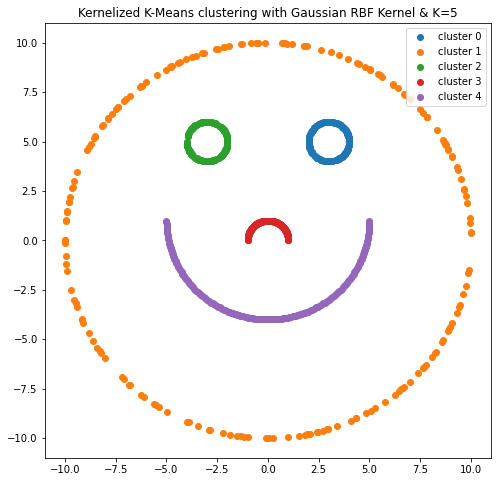

In [13]:
# Init an estimator of class `K_Means_kernelized`
clf_kernel = K_Means_kernelized(n_clusters=5, tol=1e-9, max_iter=300, sigma=X.std()*0.9)

# Transform the trainig samples & fit the estimator on traing samples in the transformed space
clf_kernel.fit_predict(clf_kernel.transform(X))

fig = getFigure(8, 8)

# Plot clustered data points
for k in range(clf_kernel.n_clusters):
    idx = clf_kernel.cluster_indices[k]
    plt.scatter(X[idx, 0], X[idx, 1], label=f'cluster {k}')

# # Plot centroids
# plt.scatter(clf_kernel.cluster_centers[0,:], clf_kernel.cluster_centers[1,:], s=100, c='black', marker='*')

plt.title(f'Kernelized K-Means clustering with Gaussian RBF Kernel & K={clf_kernel.n_clusters}')
plt.legend()
plt.show()
